# Question 1

In [78]:
import numpy as np
import pandas as pd
from scipy import stats

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("C:/Users/rthak/Python Notebooks/Data_shopify.csv")

In [3]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


#### Checking for missing values

In [5]:
df.isna().any()

order_id          False
shop_id           False
user_id           False
order_amount      False
total_items       False
payment_method    False
created_at        False
dtype: bool

#### In description of our dataset, we can see that order amount has an average value of 3145.13
#### which is naively calculated without taking it's distribution into consideration

In [9]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


In [10]:
df['created_at']=pd.to_datetime(df['created_at'])

In [11]:
df.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
payment_method            object
created_at        datetime64[ns]
dtype: object

#### Splitting Date Time

In [12]:
df['Time'],df['Date']= df['created_at'].apply(lambda x:x.time()), df['created_at'].apply(lambda x:x.date())

In [16]:
df.drop(['created_at'],axis=1,inplace=True)

In [62]:
df=df.sort_values(by='Date')

In [46]:
df_1=pd.DataFrame(df.groupby('shop_id')['order_amount'].sum())

In [72]:
df['Date']=pd.to_datetime(df['Date'])

In [73]:
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

## Checking For Duplicate Orders
#### As we can see below shop id 42 is creating duplicate orders at exact same time but on different dates.
#### On date 2017-03-28 same type of order appears twice with different order id at exact same time
#### These values can be an outlier orders.

In [102]:
duplicates = df[df.duplicated(['Time','Date','day','month','year','shop_id','user_id','order_amount','total_items','payment_method'])]
duplicates

,order_id,shop_id,user_id,order_amount,total_items,payment_method,Time,Date,day,month,year
4646,4647,42,607,704000,2000,credit_card,04:00:00,2017-03-02,2,3,2017
15,16,42,607,704000,2000,credit_card,04:00:00,2017-03-07,7,3,2017
1104,1105,42,607,704000,2000,credit_card,04:00:00,2017-03-24,24,3,2017
2835,2836,42,607,704000,2000,credit_card,04:00:00,2017-03-28,28,3,2017
4056,4057,42,607,704000,2000,credit_card,04:00:00,2017-03-28,28,3,2017


## Visualizing Outliers
#### As we can see in the scatterplot below, there are outliers in order amount.
#### Thus we cannot see distribution of order amount clearly. 
#### That is most important reason why our average order value was coming out wrong.

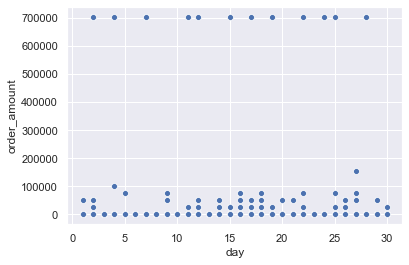

In [80]:
sns.set()
ax=sns.scatterplot(x='day',y='order_amount',data=df)

## There are two ways in which this can be tackled\

#### 1. Take order values between 25% and 75% Inter Quartile Range, then take its average
#### 2. Standardize data by scaling it between 0 to 1 , then check its distribution

In [103]:
iqr = df['order_amount'][df['order_amount'].between(df['order_amount'].quantile(.25), df['order_amount'].quantile(.75), inclusive=True)]

### We follow first method to get an average order value of 275.18

In [104]:
print("Average Order Value is:",iqr.mean())

Average Order Value is: 275.18131651556956


### I would report average basket value as a metric for above dataset for gaining more useful insights on each customer.
### This makes sure we get an insight on average number of items per order, average amount spent per order

In [105]:
iqr_total_items = df['total_items'][df['total_items'].between(df['total_items'].quantile(.25), df['total_items'].quantile(.75), inclusive=True)]

### Here as well we take interquartile range into account to gain more useful insight.
####  we round of average number of items to its closest integer since items like sneakers cannot be purchased in fractions

In [109]:
print("Average number of items bought per order:",round(iqr_total_items.mean(),0))

Average number of items bought per order: 2.0


#### As we see above average number of items bought per order is 2 and average order value is 275.18 dollars.

# Question 2 (SQL)

## a. How many orders were shipped by speedy express in total
### Answer : 54

In [ ]:
SELECT count(OrderID), ShipperName From Orders
Inner JOIN Shippers on Orders.ShipperID = Shippers.ShipperID 
where ShipperName=="Speedy Express"

## b. what is last name of employee with most number of orders
### Answer: Peacock with 40 total orders

In [ ]:
Select LastName, max(total_orders)
From(Select Employees.LastName, count(OrderID) as total_orders from Employees
join Orders on Employees.EmployeeID = Orders.EmployeeID
group by Employees.EmployeeID) 

## What product was ordered the most by customers in Germany?
### Answer: Gorgonzola Telino ordered 5 times

In [ ]:
select table_3.productname,max(count_product)
from
(select count(table_2.productid) as count_product,products.productname
from 
(select orderdetails.productid,table_1.orderid
from
(select customers.customerid,orders.orderid,customers.country
from customers
join orders on orders.customerid=customers.customerid
where customers.country=="Germany")table_1
join orderdetails on table_1.orderid=orderdetails.orderid)table_2
join products on table_2.productid=products.productid
group by products.productid)table_3

        